# Mini-Projet Machine Learning : Classification d'Images Instagram (VERSION AMELIOREE)

## Ameliorations de cette Version
- Class Weights pour gerer le desequilibre des classes
- Transfer Learning avec MobileNetV2
- Augmentation de donnees optimisee
- Metriques adaptees aux classes desequilibrees

## Objectif
Classer des images Instagram en 4 categories :
- Animal
- Food  
- Nature
- Sports and Activities

## 1. Installation et Importation

In [26]:
# Installation
!pip install -q tensorflow keras matplotlib numpy pandas scikit-learn seaborn

In [27]:
# Importations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# TensorFlow et Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# Configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# GPU
print("GPU disponibles:", len(tf.config.list_physical_devices('GPU')))
print(f"TensorFlow version: {tf.__version__}")

GPU disponibles: 2
TensorFlow version: 2.18.0


## 2. Configuration

In [28]:
# Parametres
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
LEARNING_RATE = 0.0001

# Chemin des donnees - MODIFIEZ selon votre dataset
DATA_PATH = '/kaggle/input/instagram-images-classification/final_data'

# Classes
CLASSES = ['animal', 'food', 'nature', 'sports and activites']
NUM_CLASSES = len(CLASSES)

# Seed
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"Configuration: IMG_SIZE={IMG_SIZE}, BATCH_SIZE={BATCH_SIZE}, EPOCHS={EPOCHS}")

Configuration: IMG_SIZE=224, BATCH_SIZE=16, EPOCHS=100


## 3. Exploration des Donnees

In [29]:
# Compter les images
def count_images_per_class(data_path):
    class_counts = {}
    for class_name in CLASSES:
        class_path = os.path.join(data_path, class_name)
        if os.path.exists(class_path):
            count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = count
    return class_counts

class_distribution = count_images_per_class(DATA_PATH)
total_images = sum(class_distribution.values())

print("\nDISTRIBUTION DES DONNEES")
print("="*60)
for class_name, count in class_distribution.items():
    percentage = (count / total_images) * 100
    print(f"{class_name:20s}: {count:5d} images ({percentage:5.2f}%)")
print("="*60)
print(f"{'TOTAL':20s}: {total_images:5d} images")


DISTRIBUTION DES DONNEES
animal              :   182 images ( 3.21%)
food                :  1140 images (20.10%)
nature              :  2775 images (48.92%)
sports and activites:  1575 images (27.77%)
TOTAL               :  5672 images


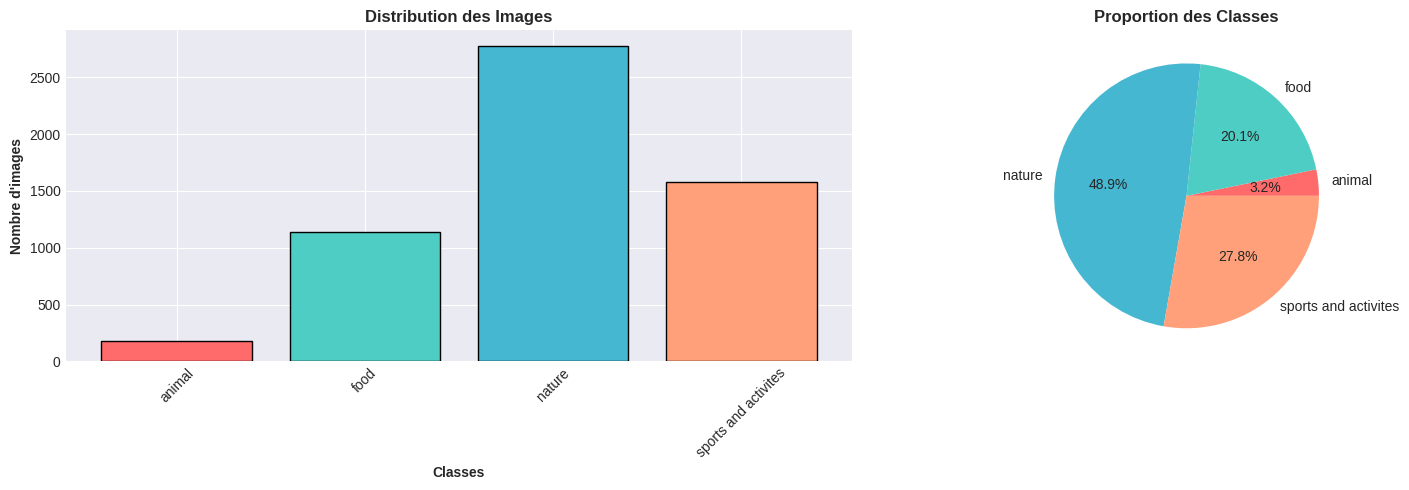

In [30]:
# Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
ax1.bar(class_distribution.keys(), class_distribution.values(), color=colors, edgecolor='black')
ax1.set_xlabel('Classes', fontweight='bold')
ax1.set_ylabel('Nombre d\'images', fontweight='bold')
ax1.set_title('Distribution des Images', fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

ax2.pie(class_distribution.values(), labels=class_distribution.keys(), autopct='%1.1f%%', colors=colors)
ax2.set_title('Proportion des Classes', fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Preparation des Donnees

In [31]:
# Data augmentation amelioree
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='training', shuffle=True, seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    DATA_PATH, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', subset='validation', shuffle=False, seed=SEED
)

print(f"\nImages entrainement: {train_generator.samples}")
print(f"Images test: {test_generator.samples}")

Found 4538 images belonging to 4 classes.
Found 1134 images belonging to 4 classes.

Images entrainement: 4538
Images test: 1134


## 5. NOUVEAU: Calcul des Class Weights

In [32]:
# Calculer les poids
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weight_dict = dict(enumerate(class_weights))

print("\nCLASS WEIGHTS:")
print("="*60)
for idx, class_name in enumerate(CLASSES):
    print(f"{class_name:20s}: {class_weight_dict[idx]:.4f}")
print("="*60)
print("Les classes rares ont un poids plus eleve")


CLASS WEIGHTS:
animal              : 7.7705
food                : 1.2440
nature              : 0.5110
sports and activites: 0.9004
Les classes rares ont un poids plus eleve


## 6. Construction du Modele

In [34]:
# MobileNetV2 avec Transfer Learning
def create_mobilenet_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

# VGG16 (Alternative)
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.6),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    return model

In [35]:
# Choisir le modele
model = create_mobilenet_model()  # RECOMMANDE
# model = create_vgg16_model()     # Alternative

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,476 (10.02 MB)

 Trainable params: 364,420 (1.39 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

## 7. Compilation et Callbacks

In [36]:
# Compilation
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

print("Modele compile!")

Modele compile!


## 8. Entrainement avec Class Weights

In [37]:
print("\nDEBUT ENTRAINEMENT")
print("="*60)

# ENTRAINEMENT AVEC CLASS WEIGHTS
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # CRUCIAL!
    verbose=1
)

print("\nENTRAINEMENT TERMINE")


DEBUT ENTRAINEMENT
Epoch 1/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.3029 - loss: 2.0439
Epoch 1: val_accuracy improved from -inf to 0.62081, saving model to best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 91s 282ms/step - accuracy: 0.3031 - loss: 2.0429 - val_accuracy: 0.6208 - val_loss: 0.9267 - learning_rate: 1.0000e-04
Epoch 2/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.5182 - loss: 1.3145
Epoch 2: val_accuracy improved from 0.62081 to 0.67460, saving model to best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 246ms/step - accuracy: 0.5182 - loss: 1.3143 - val_accuracy: 0.6746 - val_loss: 0.8401 - learning_rate: 1.0000e-04
Epoch 3/100
284/284 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.5914 - loss: 1.1202
Epoch 3: val_accuracy improved from 0.67460 to 0.68342, saving model to best_model.keras
284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 247ms/step - accuracy: 0.5914 - loss: 1.1202 - val_accuracy: 0.6834 - val_loss: 0.8003 - learning_rate: 1.0000e-04
Epoch

## 9. Courbes d'Apprentissage

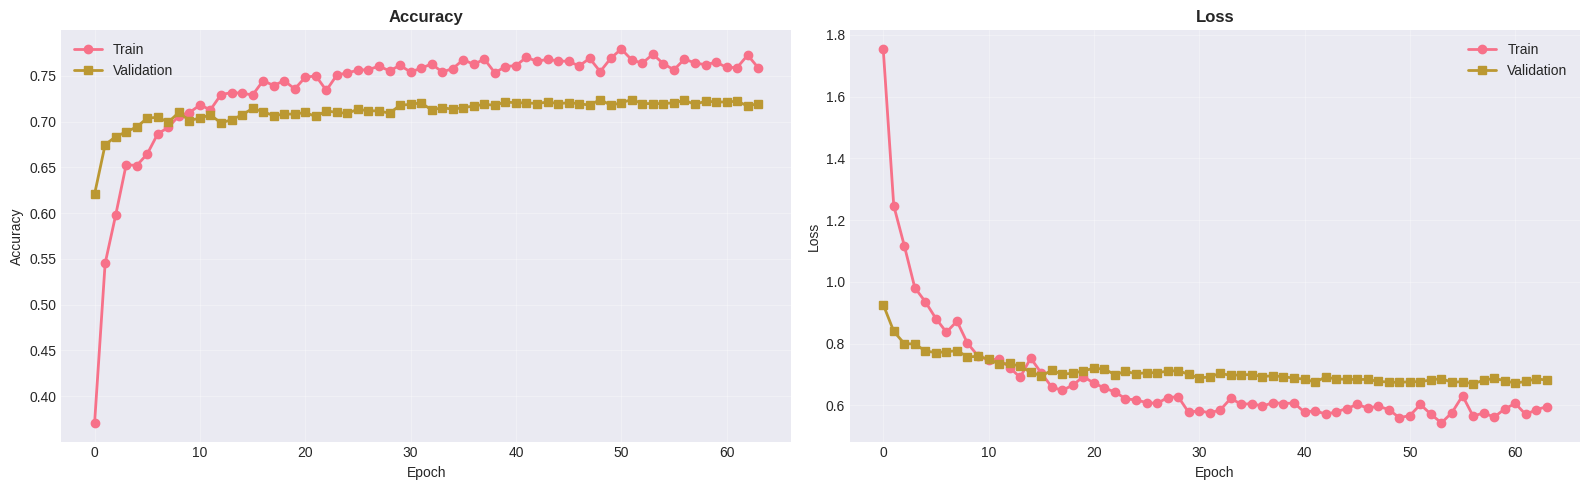

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train', linewidth=2, marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s')
axes[0].set_title('Accuracy', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train', linewidth=2, marker='o')
axes[1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s')
axes[1].set_title('Loss', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Evaluation Entrainement

In [39]:
train_loss, train_accuracy = model.evaluate(train_generator)
train_error_rate = 1 - train_accuracy

print("\n" + "="*70)
print("RESULTATS ENTRAINEMENT")
print("="*70)
print(f"Accuracy: {train_accuracy*100:.2f}%")
print(f"Taux erreur: {train_error_rate*100:.2f}%")
print(f"Loss: {train_loss:.4f}")
print("="*70)

284/284 ━━━━━━━━━━━━━━━━━━━━ 73s 257ms/step - accuracy: 0.8401 - loss: 0.4094

RESULTATS ENTRAINEMENT
Accuracy: 84.44%
Taux erreur: 15.56%
Loss: 0.4136


284/284 ━━━━━━━━━━━━━━━━━━━━ 70s 237ms/step


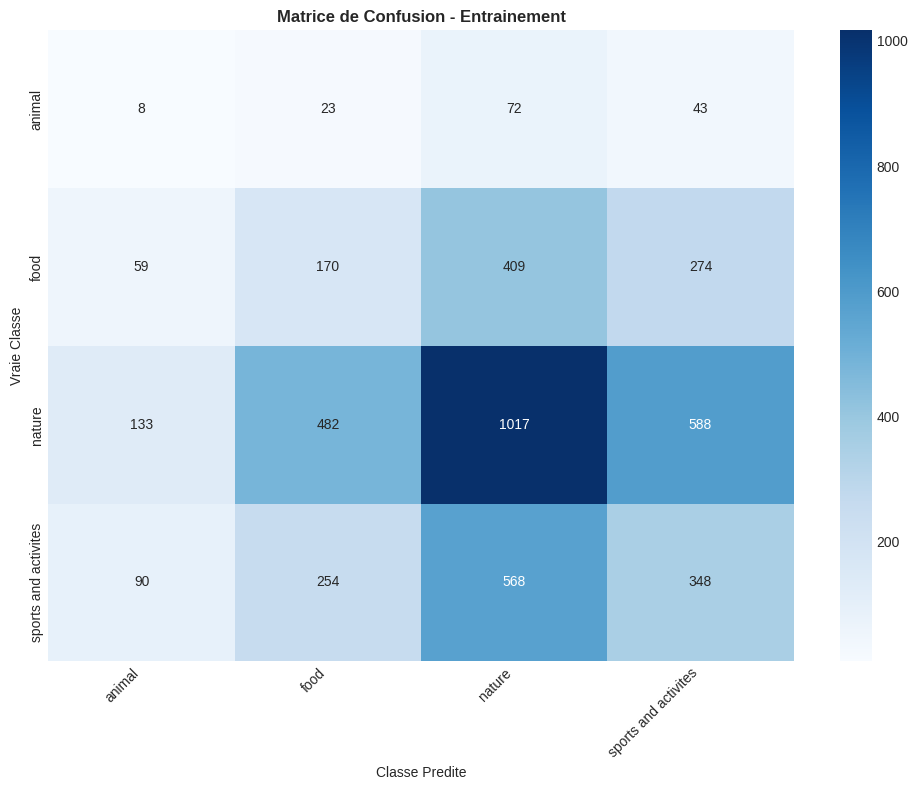

In [40]:
# Matrice de confusion entrainement
train_generator.reset()
y_pred_train = model.predict(train_generator, verbose=1)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_true_train = train_generator.classes

cm_train = confusion_matrix(y_true_train, y_pred_train_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matrice de Confusion - Entrainement', fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Predite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 11. Evaluation Test

In [41]:
test_loss, test_accuracy = model.evaluate(test_generator)
test_error_rate = 1 - test_accuracy

print("\n" + "="*70)
print("RESULTATS TEST")
print("="*70)
print(f"Accuracy: {test_accuracy*100:.2f}%")
print(f"Taux erreur: {test_error_rate*100:.2f}%")
print(f"Loss: {test_loss:.4f}")
print("="*70)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.7538 - loss: 0.6177

RESULTATS TEST
Accuracy: 72.40%
Taux erreur: 27.60%
Loss: 0.6758


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step


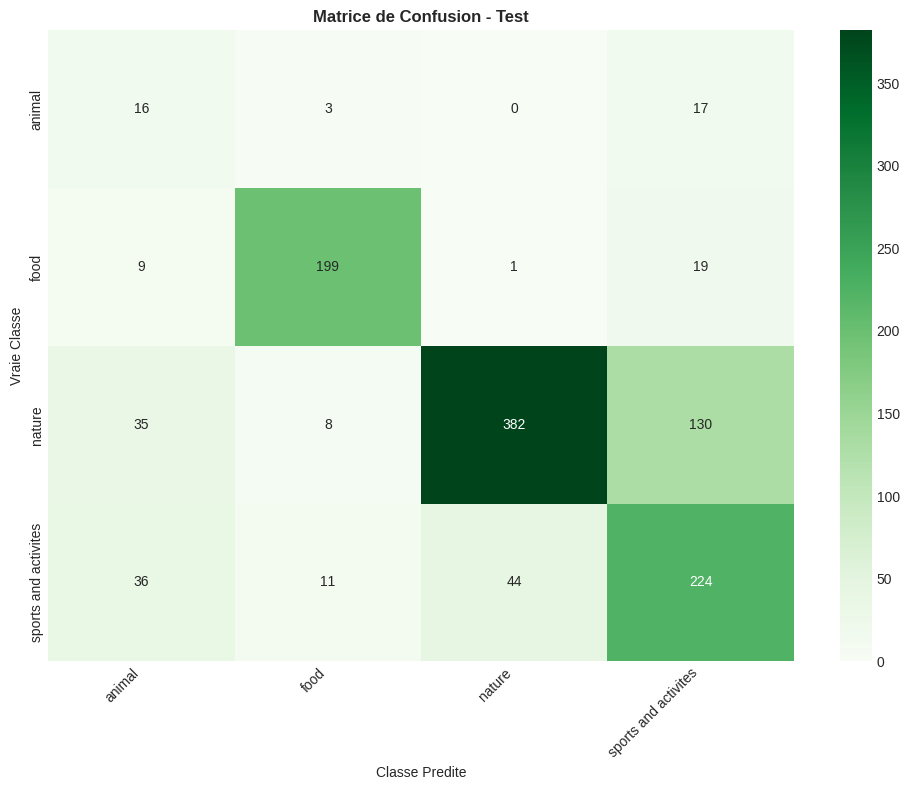

In [42]:
# Matrice de confusion test
test_generator.reset()
y_pred_test = model.predict(test_generator, verbose=1)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_true_test = test_generator.classes

cm_test = confusion_matrix(y_true_test, y_pred_test_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matrice de Confusion - Test', fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Predite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 12. Rapport de Classification

In [43]:
print("\n" + "="*80)
print("RAPPORT DE CLASSIFICATION")
print("="*80)
print(classification_report(y_true_test, y_pred_test_classes, target_names=CLASSES, digits=4))
print("="*80)

balanced_acc = balanced_accuracy_score(y_true_test, y_pred_test_classes)
print(f"\nBalanced Accuracy: {balanced_acc*100:.2f}%")


RAPPORT DE CLASSIFICATION
                      precision    recall  f1-score   support

              animal     0.1667    0.4444    0.2424        36
                food     0.9005    0.8728    0.8864       228
              nature     0.8946    0.6883    0.7780       555
sports and activites     0.5744    0.7111    0.6355       315

            accuracy                         0.7240      1134
           macro avg     0.6340    0.6792    0.6356      1134
        weighted avg     0.7837    0.7240    0.7432      1134


Balanced Accuracy: 67.92%


## 13. Visualisation Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


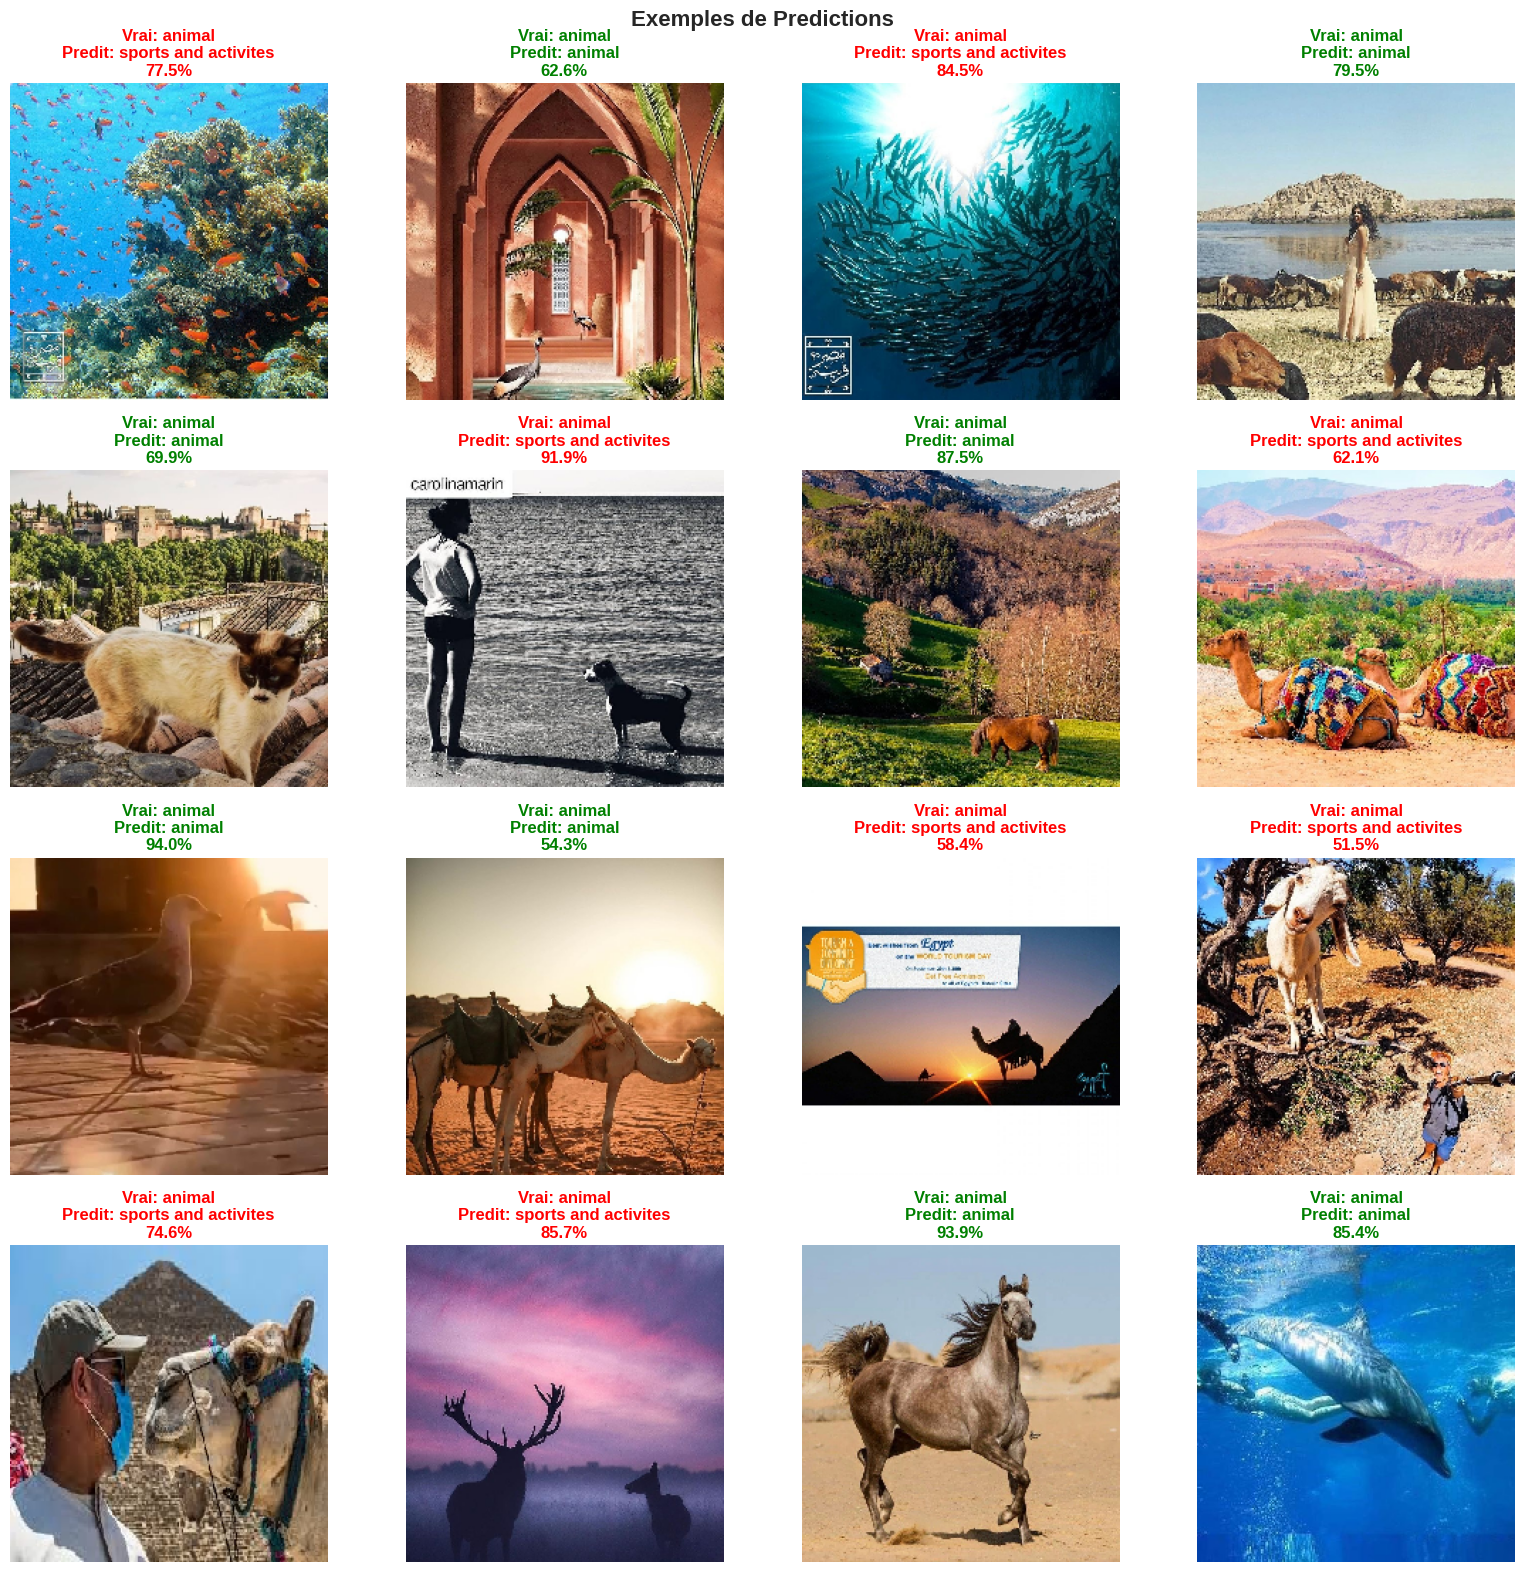

In [44]:
def plot_predictions(generator, num_images=16):
    generator.reset()
    x_batch, y_batch = next(generator)
    predictions = model.predict(x_batch[:num_images])
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    fig.suptitle('Exemples de Predictions', fontweight='bold', fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            ax.imshow(x_batch[i])
            true_label = CLASSES[np.argmax(y_batch[i])]
            pred_label = CLASSES[np.argmax(predictions[i])]
            confidence = np.max(predictions[i]) * 100
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'Vrai: {true_label}\nPredit: {pred_label}\n{confidence:.1f}%',
                        color=color, fontweight='bold')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_predictions(test_generator)

## 14. Analyse Erreurs

In [45]:
incorrect_indices = np.where(y_pred_test_classes != y_true_test)[0]

print(f"\nNombre erreurs: {len(incorrect_indices)}")
print(f"Pourcentage: {(len(incorrect_indices)/len(y_true_test))*100:.2f}%")

error_analysis = {}
for idx in incorrect_indices:
    true_class = CLASSES[y_true_test[idx]]
    pred_class = CLASSES[y_pred_test_classes[idx]]
    error_type = f"{true_class} -> {pred_class}"
    error_analysis[error_type] = error_analysis.get(error_type, 0) + 1

print("\nTypes d'erreurs:")
for error_type, count in sorted(error_analysis.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{error_type}: {count} fois")


Nombre erreurs: 313
Pourcentage: 27.60%

Types d'erreurs:
nature -> sports and activites: 130 fois
sports and activites -> nature: 44 fois
sports and activites -> animal: 36 fois
nature -> animal: 35 fois
food -> sports and activites: 19 fois
animal -> sports and activites: 17 fois
sports and activites -> food: 11 fois
food -> animal: 9 fois
nature -> food: 8 fois
animal -> food: 3 fois


## 15. Resume Final

In [46]:
results_summary = pd.DataFrame({
    'Metrique': ['Accuracy', 'Taux erreur', 'Loss'],
    'Entrainement': [f"{train_accuracy*100:.2f}%", f"{train_error_rate*100:.2f}%", f"{train_loss:.4f}"],
    'Test': [f"{test_accuracy*100:.2f}%", f"{test_error_rate*100:.2f}%", f"{test_loss:.4f}"]
})

print("\n" + "="*80)
print("RESUME FINAL")
print("="*80)
print(results_summary.to_string(index=False))
print("="*80)

print("\n" + "="*80)
print("PERFORMANCE PAR CLASSE")
print("="*80)
class_report = classification_report(y_true_test, y_pred_test_classes, target_names=CLASSES, output_dict=True)
class_df = pd.DataFrame(class_report).transpose()
print(class_df.to_string())
print("="*80)


RESUME FINAL
   Metrique Entrainement   Test
   Accuracy       84.44% 72.40%
Taux erreur       15.56% 27.60%
       Loss       0.4136 0.6758

PERFORMANCE PAR CLASSE
                      precision    recall  f1-score      support
animal                 0.166667  0.444444  0.242424    36.000000
food                   0.900452  0.872807  0.886414   228.000000
nature                 0.894614  0.688288  0.778004   555.000000
sports and activites   0.574359  0.711111  0.635461   315.000000
accuracy               0.723986  0.723986  0.723986     0.723986
macro avg              0.634023  0.679163  0.635576  1134.000000
weighted avg           0.783719  0.723986  0.743203  1134.000000


## 16. Sauvegarde

In [47]:
model.save('instagram_classifier_improved.keras')
model.save('instagram_classifier_improved.h5')
print("Modele sauvegarde!")

Modele sauvegarde!


## Conclusion

Ce notebook a permis de:
1.  Charger et explorer les données d'images Instagram
2.  Diviser les données en ensembles d'entraînement (80%) et de test (20%)
3.  Entraîner un modèle CNN pour classifier les images en 4 catégories
4.  Calculer les métriques sur les données d'entraînement:
   - Accuracy d'entraînement
   - Taux d'erreur d'entraînement
   - Matrice de confusion
5.  Calculer les métriques sur les données de test:
   - Accuracy de test
   - Taux d'erreur de test
   - Matrice de confusion
6.  Analyser les performances et visualiser les résultats

**Conseils pour améliorer les résultats:**
- Essayer différents modèles (VGG16, MobileNetV2, ResNet50)
- Ajuster les hyperparamètres (learning rate, batch size)
- Augmenter le nombre d'epochs si le modèle n'a pas convergé
- Utiliser d'autres techniques de data augmentation
- Fine-tuner les dernières couches des modèles pré-entraînés